In [7]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import math

### Lets load one of the avaliable image

In [8]:
# filename = '../images/kajdano.png'
# filename = '../images/kajdano2.png'
# filename = '../images/sebesh.png'
filename = '../images/test.png'
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

`lines = cv2.HoughLinesP(dst, 1, np.pi / 180, 50, None, 200, 12)`

TODO understand each of the parameter
with the arguments:
- dst: Output of the edge detector. It should be a grayscale image (although in fact it is a binary one)
- rho : The resolution of the parameter r in pixels. We use 1 pixel.
- theta: The resolution of the parameter θ in radians. We use 1 degree (CV_PI/180)
- threshold: The minimum number of intersections to "*detect*" a line (50)
- minLinLength: The minimum number of points that can form a line. Lines with less than this number of points are disregarded.
- maxLineGap: The maximum gap between two points to be considered in the same line.

In [9]:
from collections import OrderedDict
from collections import defaultdict

# Run edge detection
# TODO to achive better result we can adjust Canny parameters
dst = cv2.Canny(img, 50, 200, None, 3)

# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

# Find lines with Probabilistic Hough Line Transform (https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html)
lines = cv2.HoughLinesP(dst, 1, np.pi / 180, 50, None, 220, 10)

Keep only vertical and horizontal lines. If a line has angel close to 90 or 0 we also kepp it. Because the table can be a litle bit rotated.

The `HoughLinesP` find lines which are the parts of the table. But for example, a line can be shorter than table border. So we continuate the line from top to down of image if it is a vertical line or from left to right if it horizontal.

For example a vertical line `(x1=10, y1=10, x2=10,y2=200)` would be `(x1=10, y1=0, x2=10, y2=image_height])`


In [10]:
horizontal = dict()
vertical = dict()
for i in range(0, len(lines)):
    l = lines[i][0]
    angel = np.arctan2(l[3] - l[1], l[2] - l[0]) * 180. / np.pi
    if (angel > -91 and angel < -89 ):
        vertical[l[0]] = [l[0], 0, l[2], cdst.shape[0]]
    if (angel == 0 ):
        horizontal[l[1]] = [0, l[1], cdst.shape[1], l[3]]

horizontal = OrderedDict(sorted(horizontal.items()))
vertical = OrderedDict(sorted(vertical.items()))

We have a lot of duplicate lines which have almost the same X1, Y1 and X2, Y2, 
the difference only in few pixels so lets remove lines which are close to each other and keep only one in the midle.

In [11]:
def reduc_lines(lines, threshould=10):
    buckets = []
    prev = next(iter(lines.keys()))
    current_bucket = []
    
    for key in lines.keys():
        if key > threshould + prev:
            if len(current_bucket) == 0:
                buckets.append([prev])
            buckets.append(current_bucket)
            current_bucket = []
        
        current_bucket.append(key)
        prev = key
        
    if len(current_bucket) > 0:
        buckets.append(current_bucket)
    
    res = []

    for bucket in buckets:
        mean = np.mean(bucket)
        res.append(lines[min(bucket, key=lambda x: abs(x - mean))])
    return res

horizontal = reduc_lines(horizontal, 10)
vertical = reduc_lines(vertical, 10)
lines =  horizontal + vertical
for l in lines:
    cv2.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

### Find line intersection as point of table cells

TODO this code was copy-pasted from stackowerflow should be reviewed

In [12]:
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return int(x), int(y)
    else:
        return False

dots = []

# Find intersection of horizontal and vertical lines and plot them on image (just for observation)
for hor_line in horizontal:
    L1 = line(hor_line[:2], hor_line[2:])

    for ver_line in vertical:
        
        L2 = line(ver_line[:2], ver_line[2:])
        inter = intersection(L1, L2)
        if inter:
            dots.append(inter)
            cv2.circle(cdst, inter, 10, (255, 0, 0) , 2)
            

Just plot given image with vertical and horizontal lines and intersection points

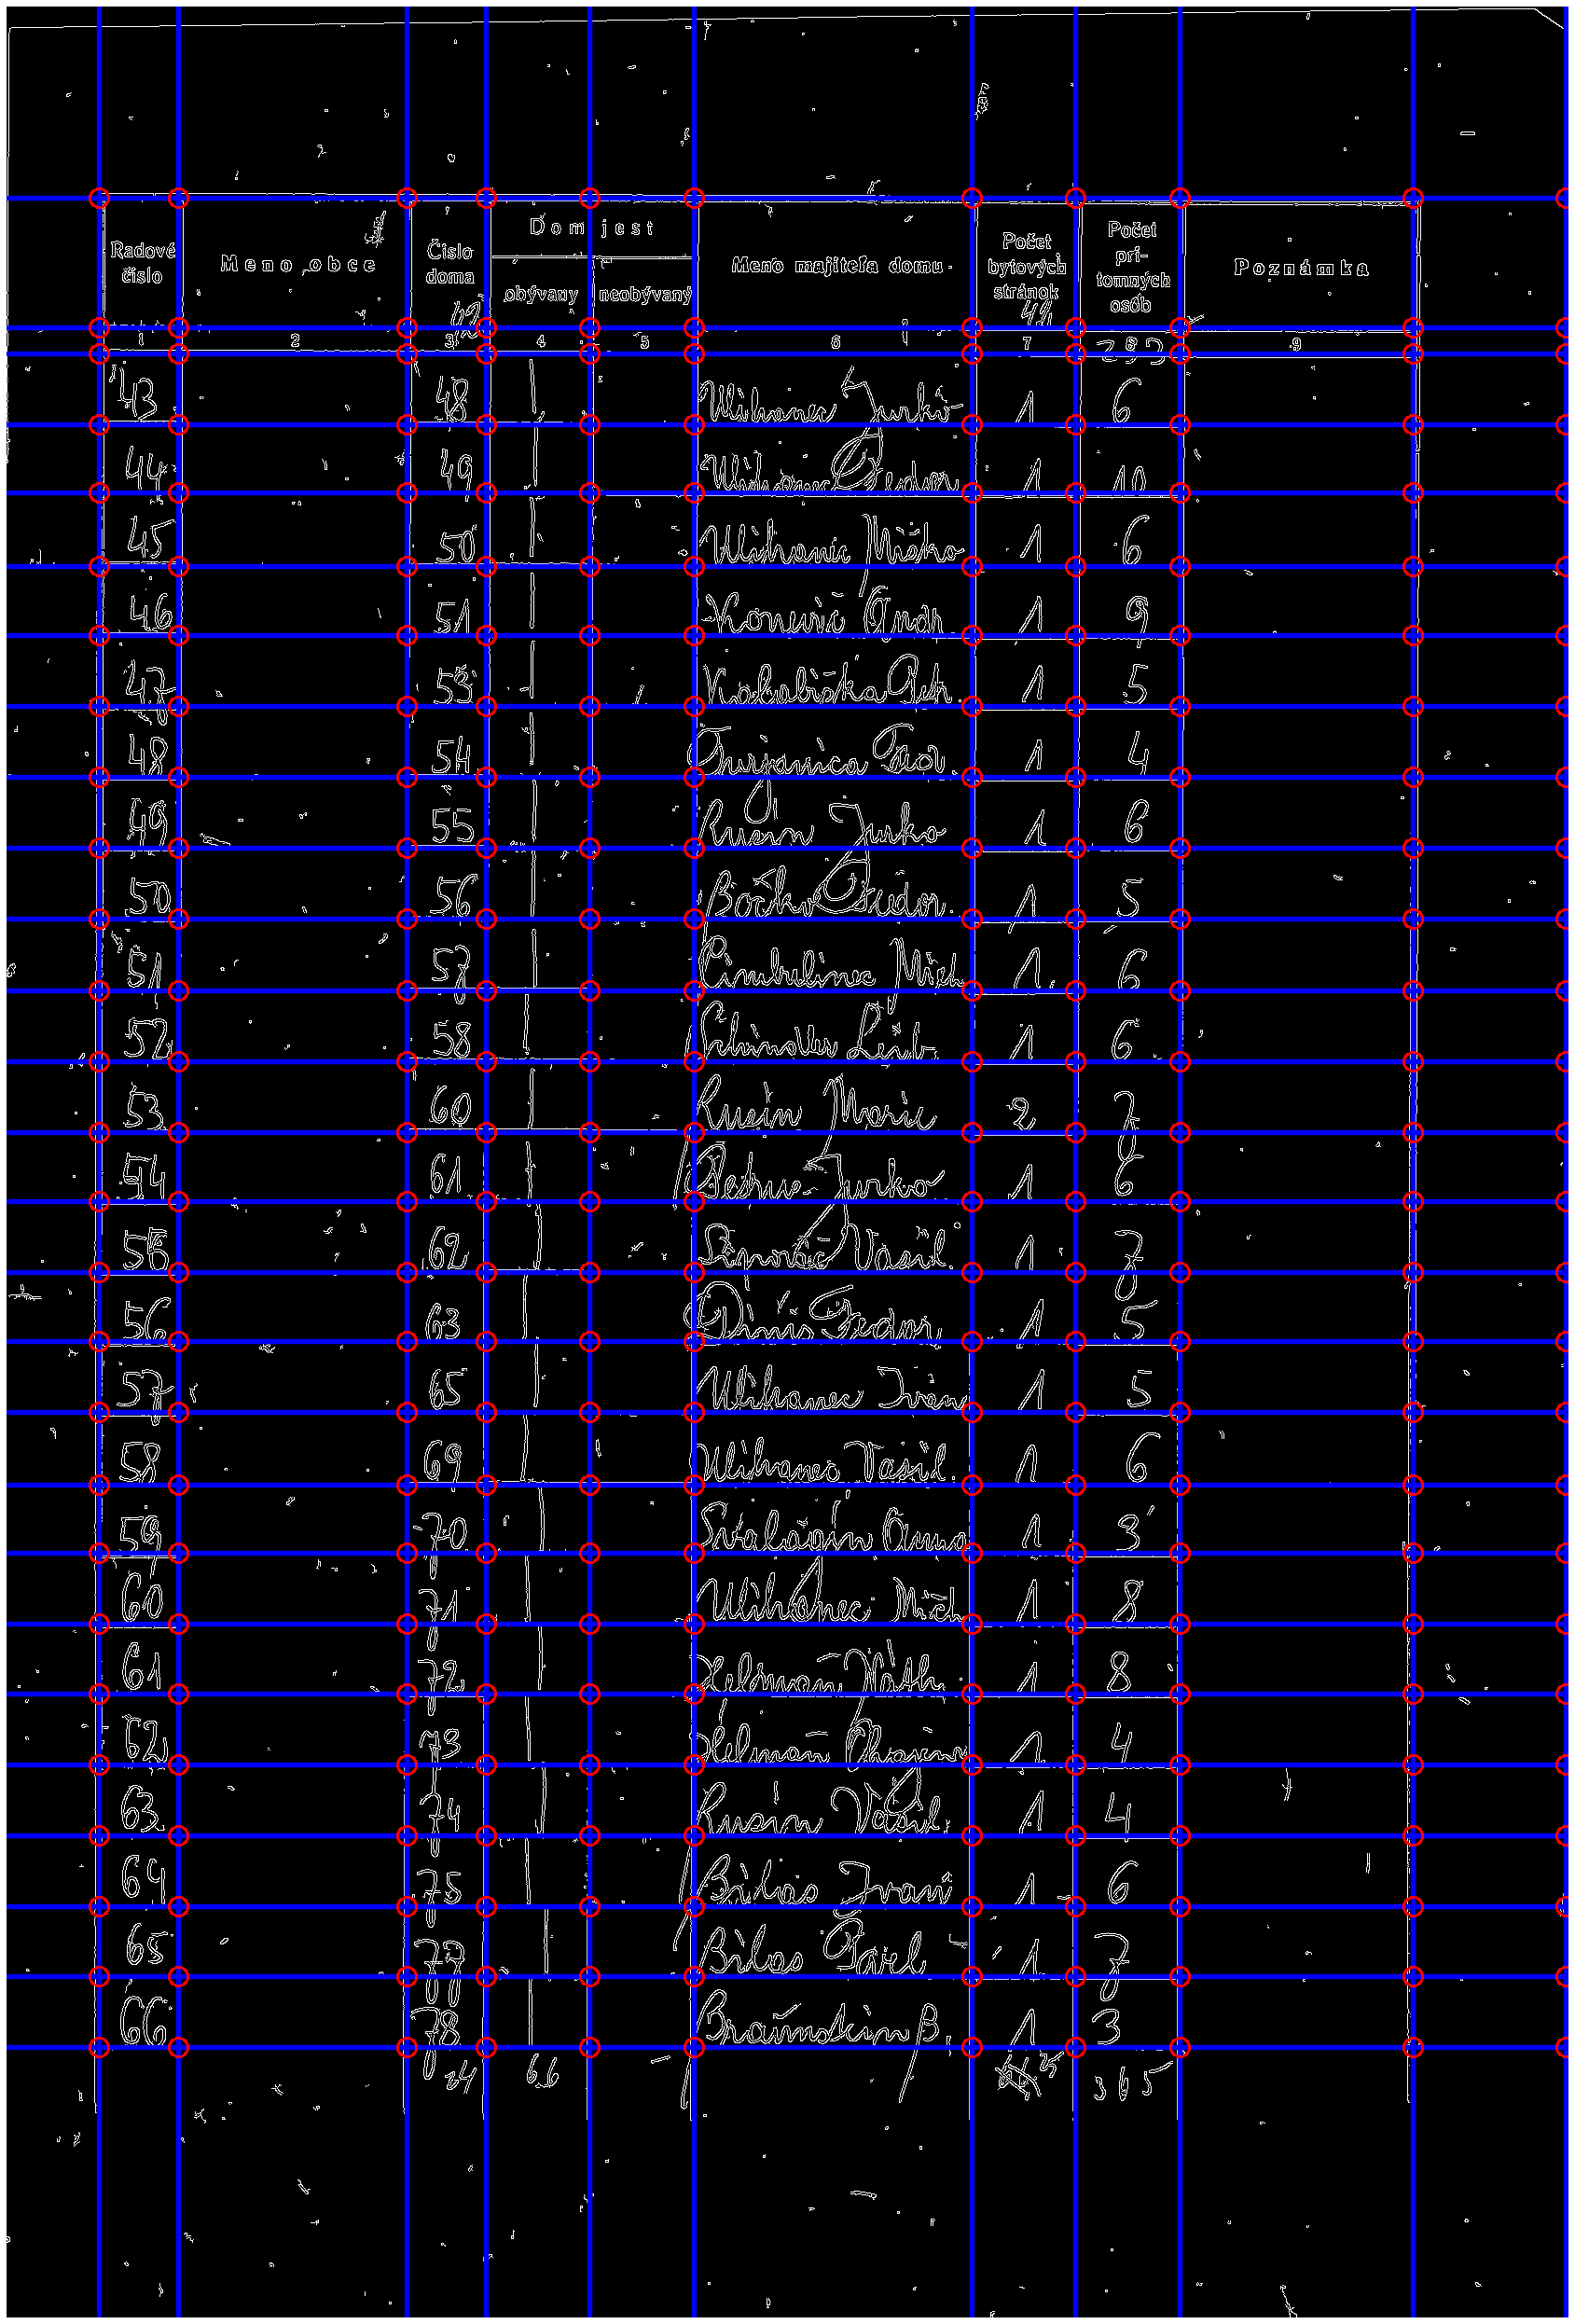

True

In [13]:
dpi = plt.rcParams['figure.dpi']
height, width, depth = cdst.shape

# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)

# Create a figure of the right size with one axes that takes up the full figure
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])

# Hide spines, ticks, etc.
ax.axis('off')

# Display the image.
ax.imshow(cdst, cmap='gray')

plt.show()

cv2.imwrite("cdst2.jpg",cdst)

## TODO

- Calculate horizontal and vertical line with different min lenght as vertical lines usualy longer than horizontal so we coud get more accurate algorithm